In [1]:
from PIL import Image, ImageFilter
import os
import imageio
import numpy as np
from scipy.ndimage import label
import time

def rgb_to_ycrcb(r, g, b):
    y  = 0.299 * r + 0.587 * g + 0.114 * b
    cr = (r - y) * 0.713 + 128
    cb = (b - y) * 0.564 + 128
    return y, cr, cb

def rgb_to_hsv(r, g, b):
    r, g, b = r / 255, g / 255, b / 255
    mx, mn = max(r, g, b), min(r, g, b)
    diff = mx - mn
    h = (
        0 if mx == mn else
        (60 * ((g - b) / diff) + 360) % 360 if mx == r else
        (60 * ((b - r) / diff) + 120) % 360 if mx == g else
        (60 * ((r - g) / diff) + 240) % 360
    )
    s = 0 if mx == 0 else (diff / mx)
    v = mx
    return h, s, v

def is_skin_pixel_robust(pixel):
    r, g, b = pixel
    y, cr, cb = rgb_to_ycrcb(r, g, b)
    h, s, v = rgb_to_hsv(r, g, b)

    rgb_rule = r > 95 and g > 40 and b > 20 and max(pixel) - min(pixel) > 15 and abs(r - g) > 15 and r > g > b
    ycrcb_rule = (135 <= cr <= 180 and 85 <= cb <= 135)
    hsv_rule = (0 <= h <= 50 and 0.2 <= s <= 0.68 and v >= 0.35)

    return rgb_rule or ycrcb_rule or hsv_rule

def contains_face_heuristic(img: Image.Image) -> bool:
    img = img.resize((224, 224)).convert("RGB")
    img = img.filter(ImageFilter.MedianFilter(size=3))
    pixels = np.array(img)

    skin_mask = np.zeros((224, 224), dtype=np.uint8)
    for i in range(224):
        for j in range(224):
            if is_skin_pixel_robust(pixels[i, j]):
                skin_mask[i, j] = 1

    total_skin_ratio = np.sum(skin_mask) / skin_mask.size
    labeled, num_features = label(skin_mask)
    largest_blob_size = max((np.sum(labeled == i) for i in range(1, num_features + 1)), default=0)
    largest_blob_ratio = largest_blob_size / skin_mask.size
    center_ratio = np.sum(skin_mask[90:134, 90:134]) / (44 * 44)

    return total_skin_ratio > 0.08 and center_ratio > 0.15 and largest_blob_ratio > 0.03

def print_colored(text, color):
    colors = {
        "green": "\033[92m", "red": "\033[91m",
        "yellow": "\033[93m", "blue": "\033[94m",
        "reset": "\033[0m"
    }
    return f"{colors.get(color, '')}{text}{colors['reset']}"

def save_preview_images(img: Image.Image, edge_img: Image.Image, video_name: str, frame_idx: int, preview_dir: str, face_detected: bool):
    status = "face" if face_detected else "no_face"
    base_name = f"{video_name}frame{frame_idx}{status}"

    original_path = os.path.join(preview_dir, f"{base_name}_original.jpg")
    edge_path = os.path.join(preview_dir, f"{base_name}_edge.jpg")

    img.save(original_path)
    edge_img.save(edge_path)

def process_videos_for_face_check(video_dir, num_samples=10, preview_dir=None):
    start_time = time.time()
    face_count = 0
    all_videos = [f for f in os.listdir(video_dir) if f.lower().endswith((".mp4", ".avi", ".mov"))]
    print(print_colored(f"🔍 Scanning {len(all_videos)} videos...\n", "blue"))

    if preview_dir and not os.path.exists(preview_dir):
        os.makedirs(preview_dir)

    for idx, video_name in enumerate(all_videos, 1):
        video_path = os.path.join(video_dir, video_name)
        print(f"[{idx}/{len(all_videos)}] Processing {video_name}... ", end="")

        try:
            vid = imageio.get_reader(video_path, 'ffmpeg')
            total_frames = vid.count_frames()
            step = max(total_frames // num_samples, 1)
            detected = False

            for i in range(0, total_frames, step):
                try:
                    frame = vid.get_data(i)
                    img = Image.fromarray(frame).convert("RGB")
                    if i == 0: 
                        visualize_preprocessing_steps(img, frame_idx=i)
                    edge_img = img.filter(ImageFilter.FIND_EDGES)

                    has_face = contains_face_heuristic(img)

                    if preview_dir:
                        save_preview_images(img, edge_img, video_name, i, preview_dir, has_face)

                    if has_face:
                        detected = True
                        break

                except Exception:
                    continue

            status = print_colored("✅ Face Detected", "green") if detected else print_colored("❌ No Face", "red")
            print(status)

            if detected:
                face_count += 1

        except Exception as e:
            print(print_colored(f"⚠ Failed: {e}", "yellow"))

    elapsed = time.time() - start_time
    print(print_colored(f"\n🎯 Total videos with faces: {face_count}/{len(all_videos)}", "blue"))
    print(print_colored(f"⏱ Completed in {elapsed:.2f} seconds.", "blue"))

import matplotlib.pyplot as plt

def visualize_preprocessing_steps(img: Image.Image, frame_idx=0):
    resized_img = img.resize((224, 224)).convert("RGB")
    smoothed_img = resized_img.filter(ImageFilter.MedianFilter(size=3))

    pixels = np.array(smoothed_img)
    skin_mask = np.zeros((224, 224), dtype=np.uint8)
    for i in range(224):
        for j in range(224):
            if is_skin_pixel_robust(pixels[i, j]):
                skin_mask[i, j] = 255

    edge_img = smoothed_img.filter(ImageFilter.FIND_EDGES)

    center_crop = skin_mask[90:134, 90:134]

    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    axs[0].imshow(resized_img)
    axs[0].set_title("Original")

    axs[1].imshow(smoothed_img)
    axs[1].set_title("Smoothed")

    axs[2].imshow(skin_mask, cmap="gray")
    axs[2].set_title("Skin Mask")

    axs[3].imshow(edge_img)
    axs[3].set_title("Edges")

    axs[4].imshow(center_crop, cmap="gray")
    axs[4].set_title("Center Skin Crop")

    for ax in axs:
        ax.axis("off")

    plt.suptitle(f"Preprocessing Visualization - Frame {frame_idx}")
    plt.tight_layout()
    plt.show()


🔍 Scanning 10 videos...

[1/10] Processing v1.mp4... 

C:\Users\kesav\AppData\Local\Temp\ipykernel_20936\846179737.py:33: RuntimeWarning: overflow encountered in scalar subtract
  rgb_rule = r > 95 and g > 40 and b > 20 and max(pixel) - min(pixel) > 15 and abs(r - g) > 15 and r > g > b


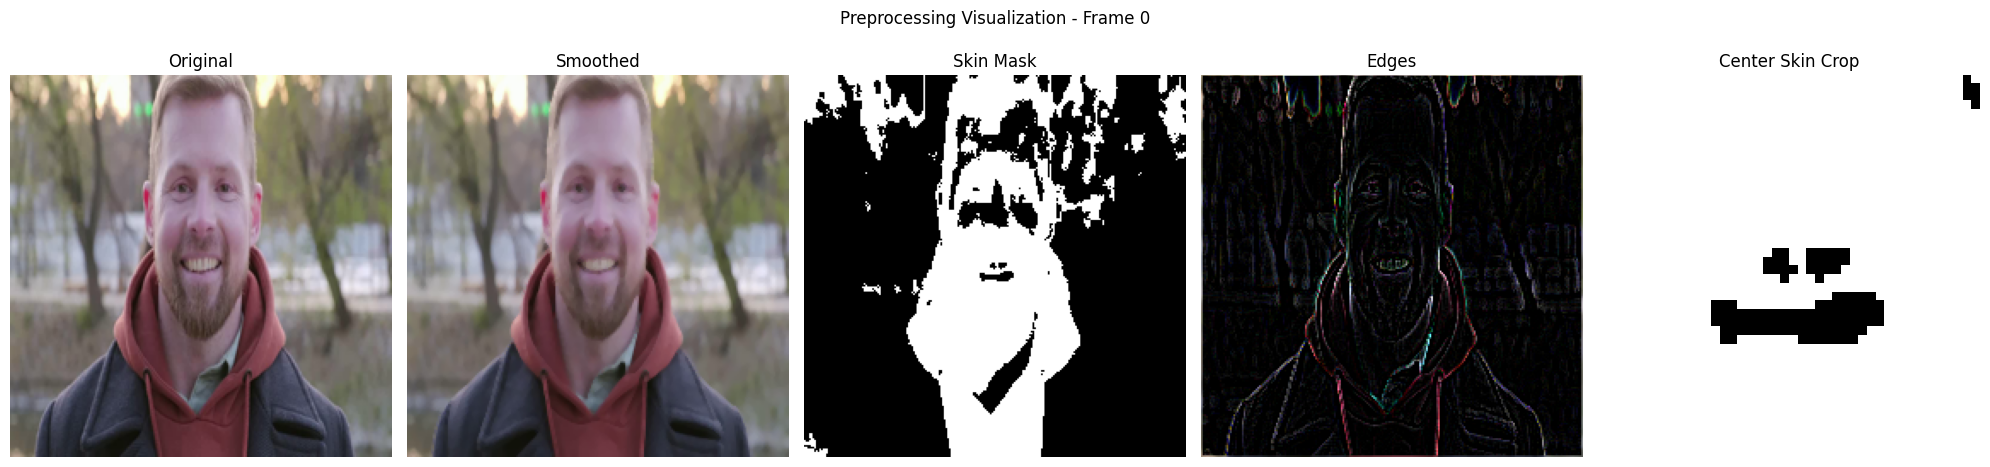

✅ Face Detected
[2/10] Processing v10.mp4... 

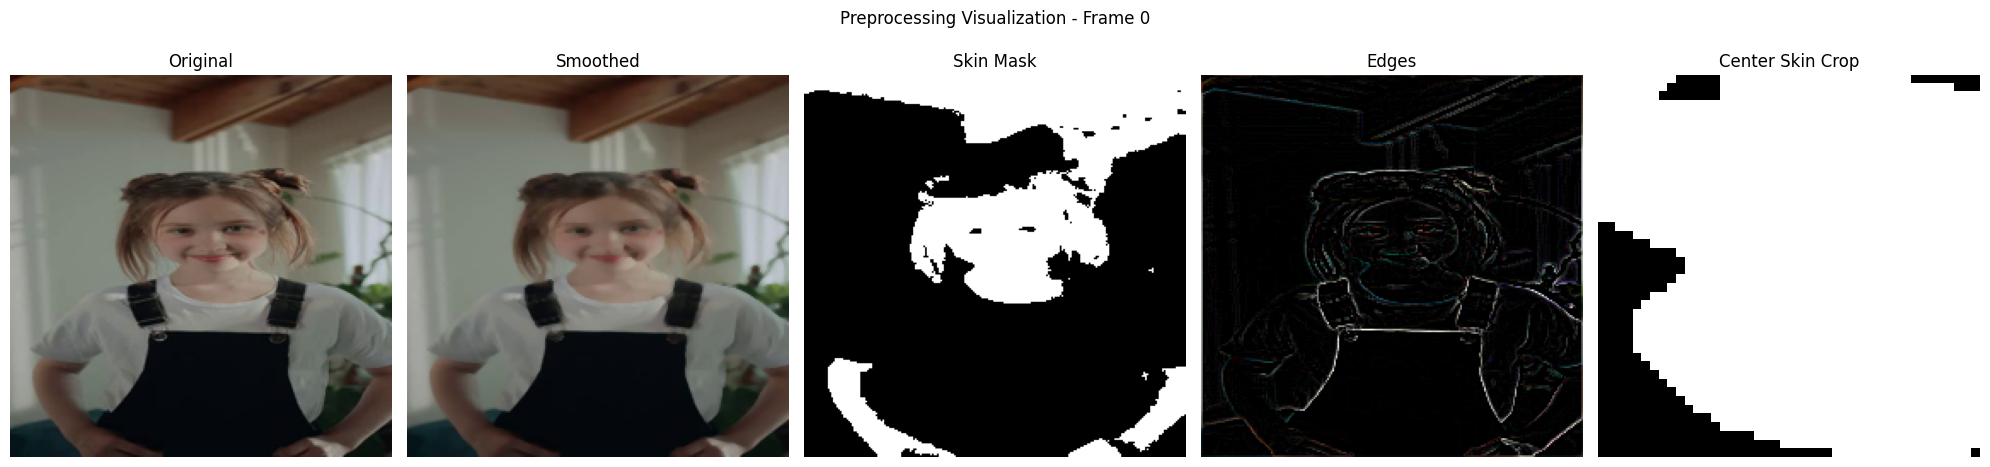

✅ Face Detected
[3/10] Processing v2.mp4... 

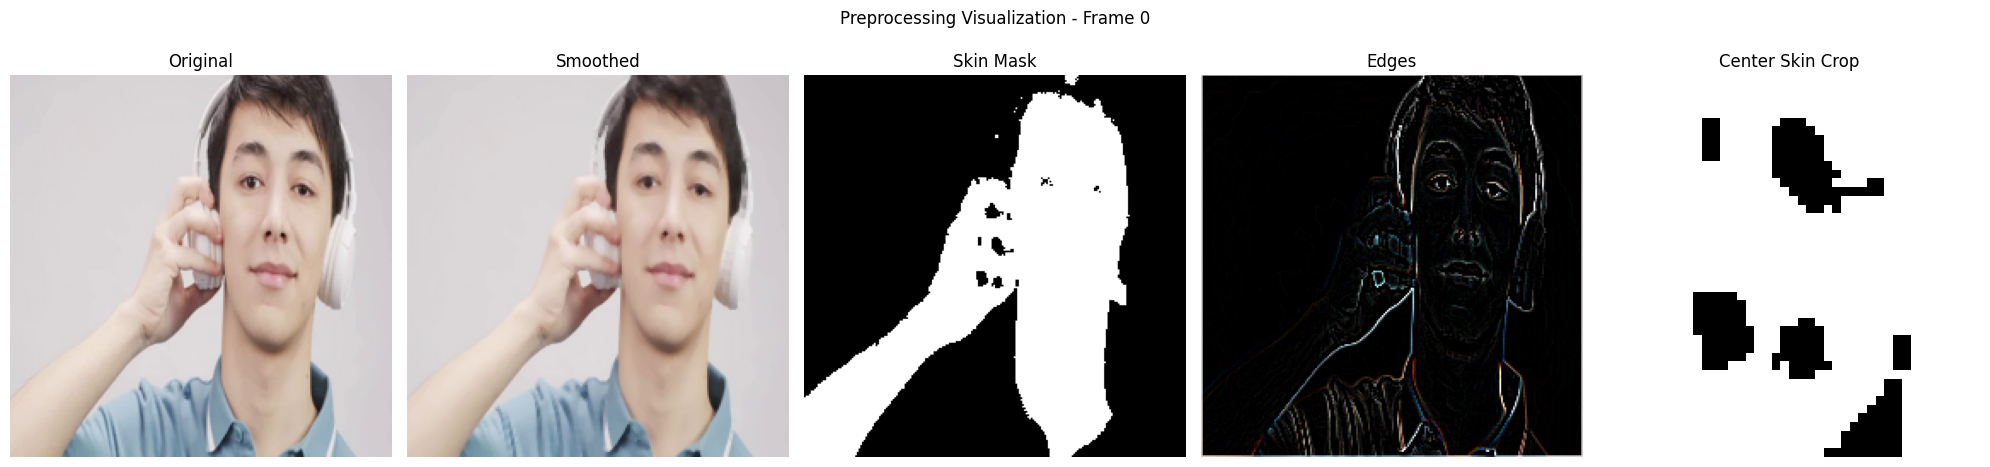

✅ Face Detected
[4/10] Processing v3.mp4... 

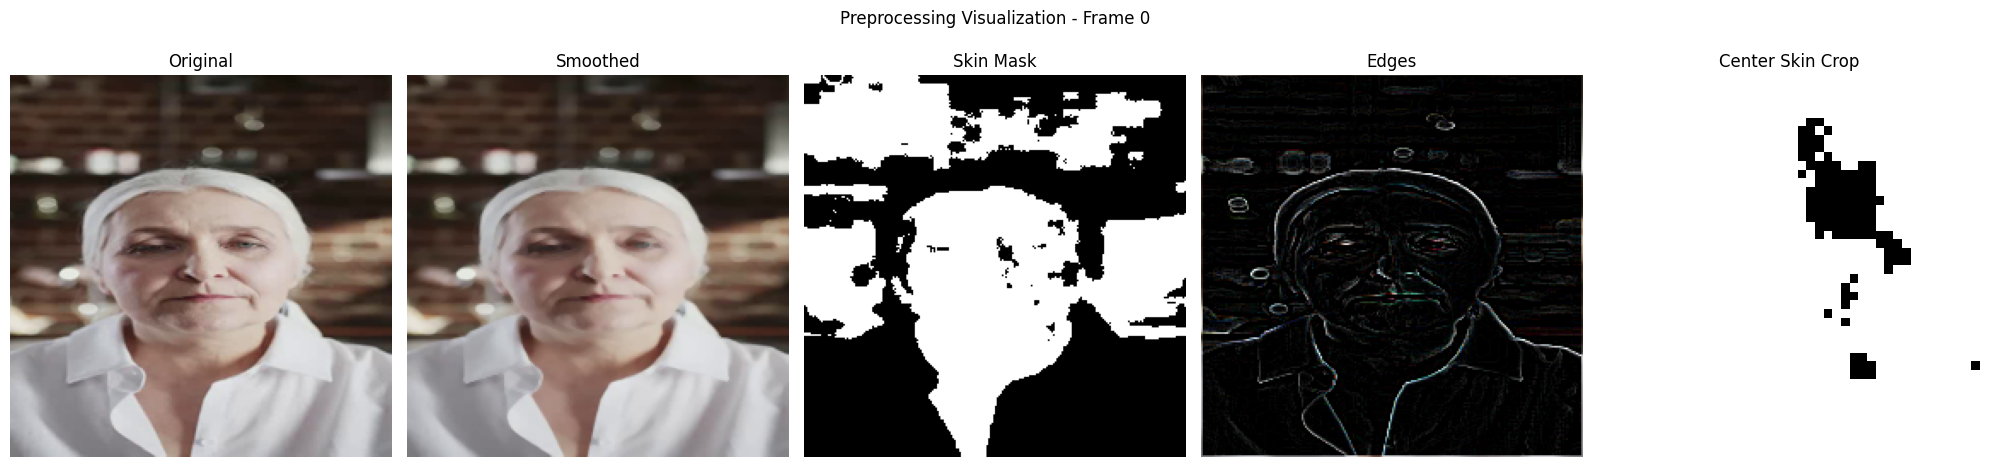

✅ Face Detected
[5/10] Processing v4.mp4... 

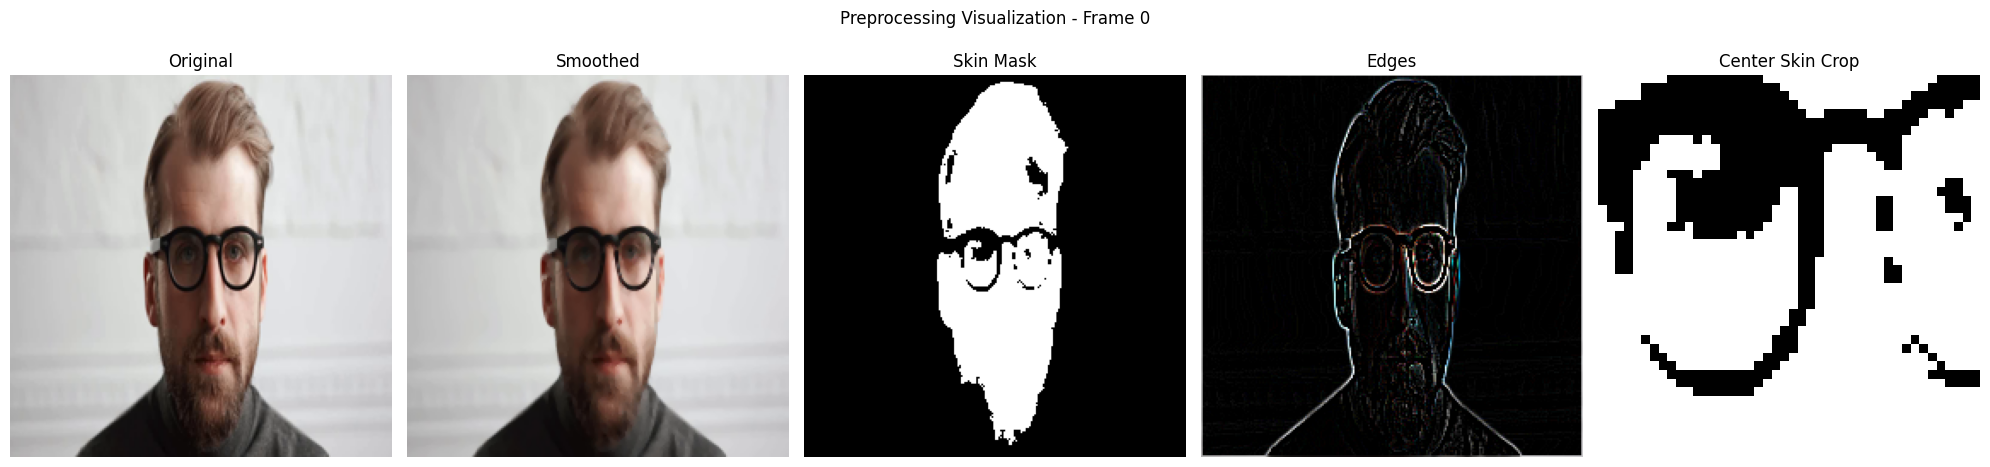

✅ Face Detected
[6/10] Processing v5.mp4... 

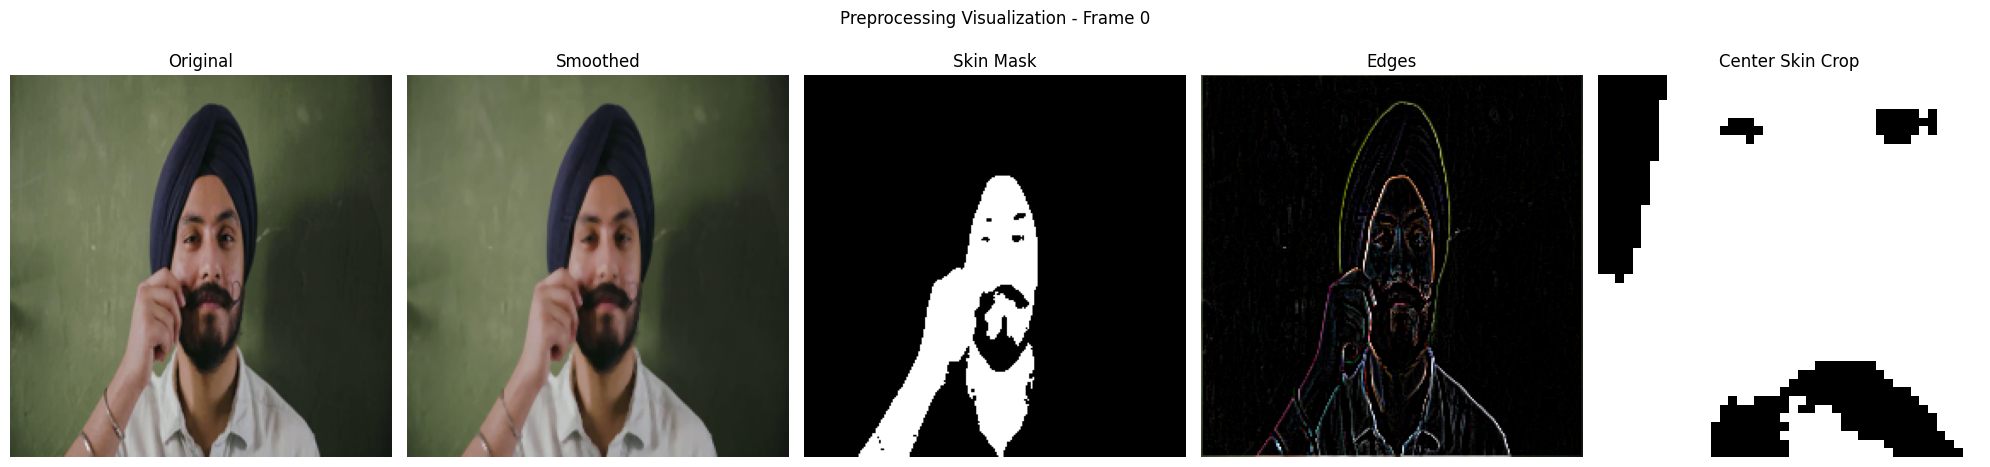

✅ Face Detected
[7/10] Processing v6.mp4... 

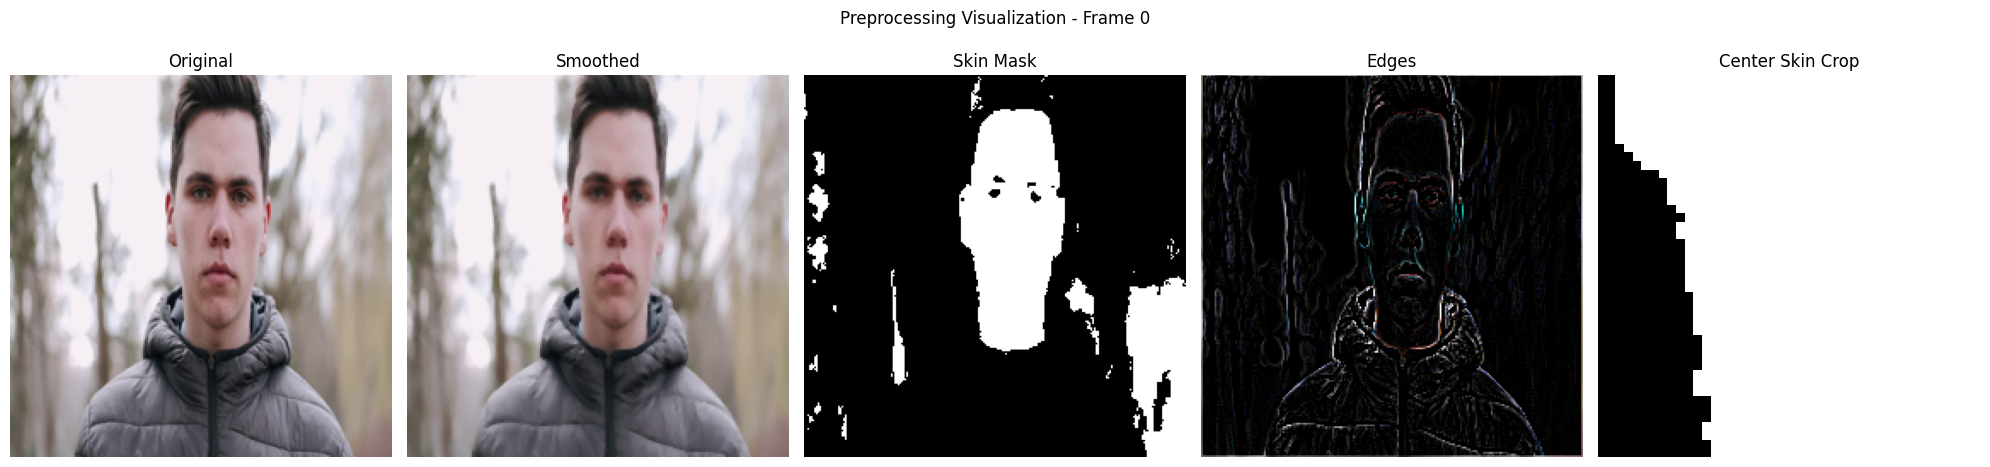

✅ Face Detected
[8/10] Processing v7.mp4... 

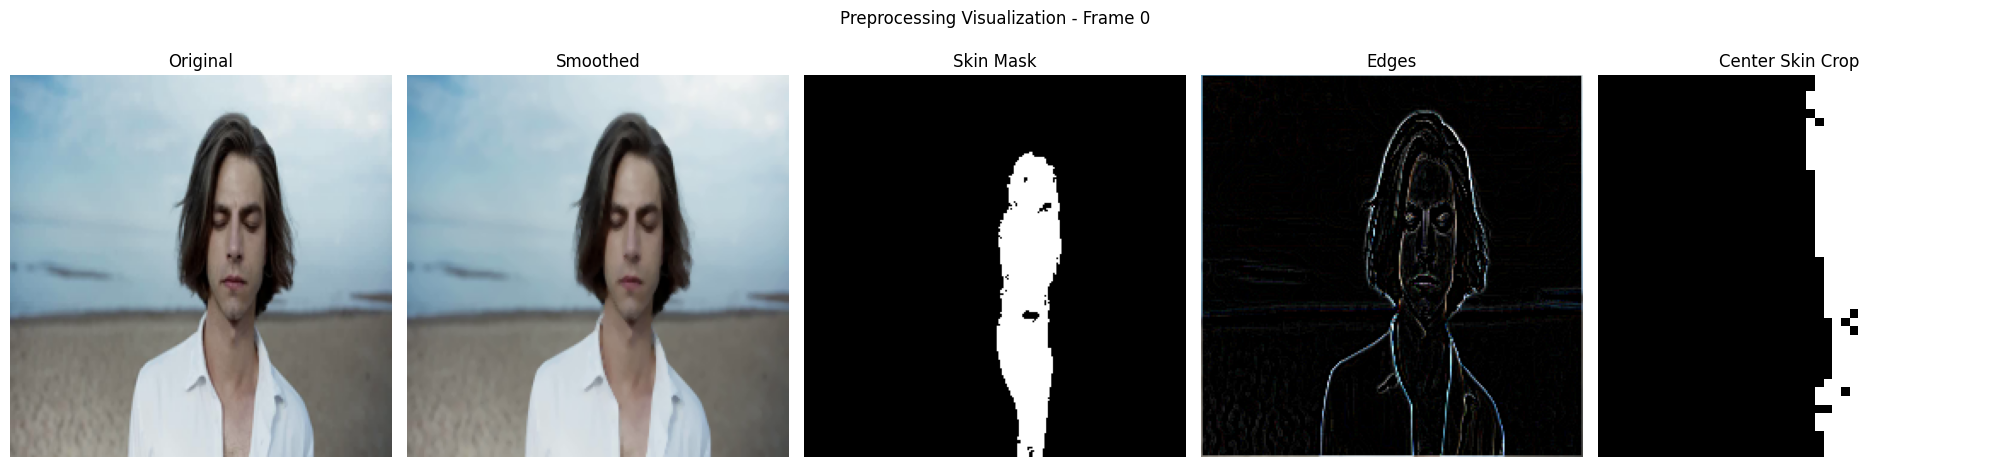

✅ Face Detected
[9/10] Processing v8.mp4... 

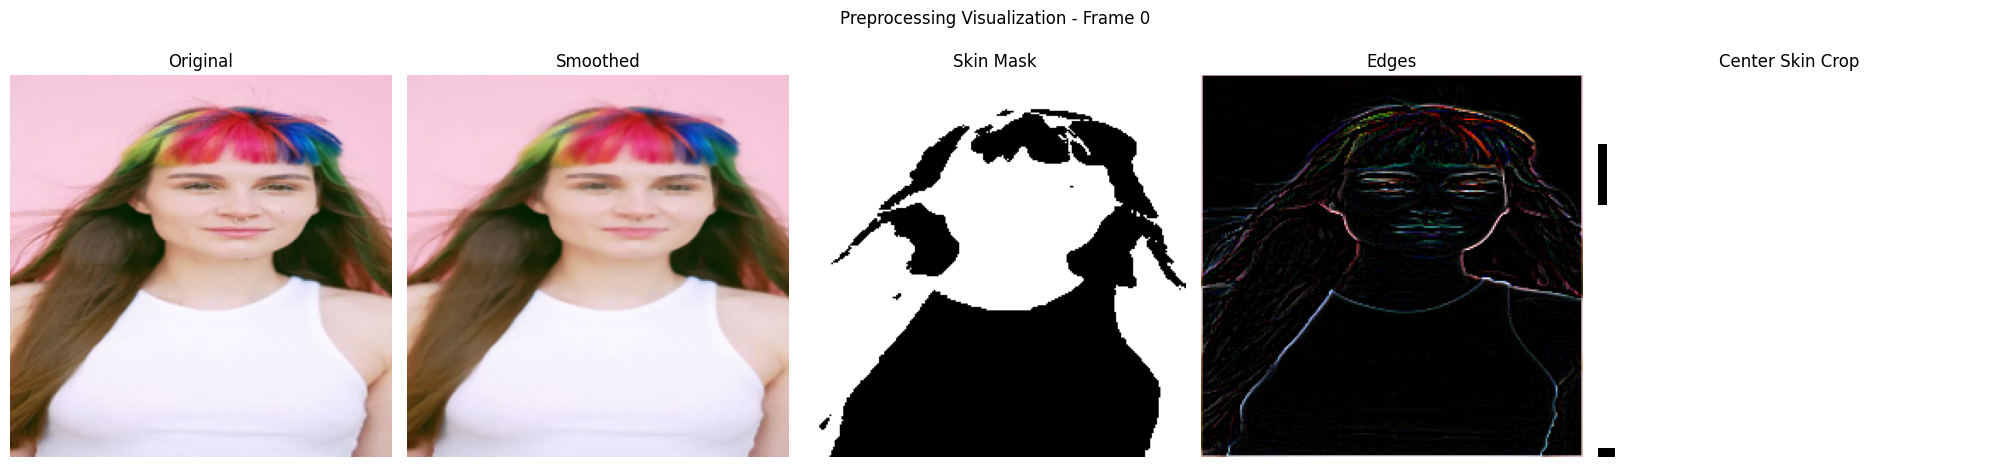

✅ Face Detected
[10/10] Processing v9.mp4... 

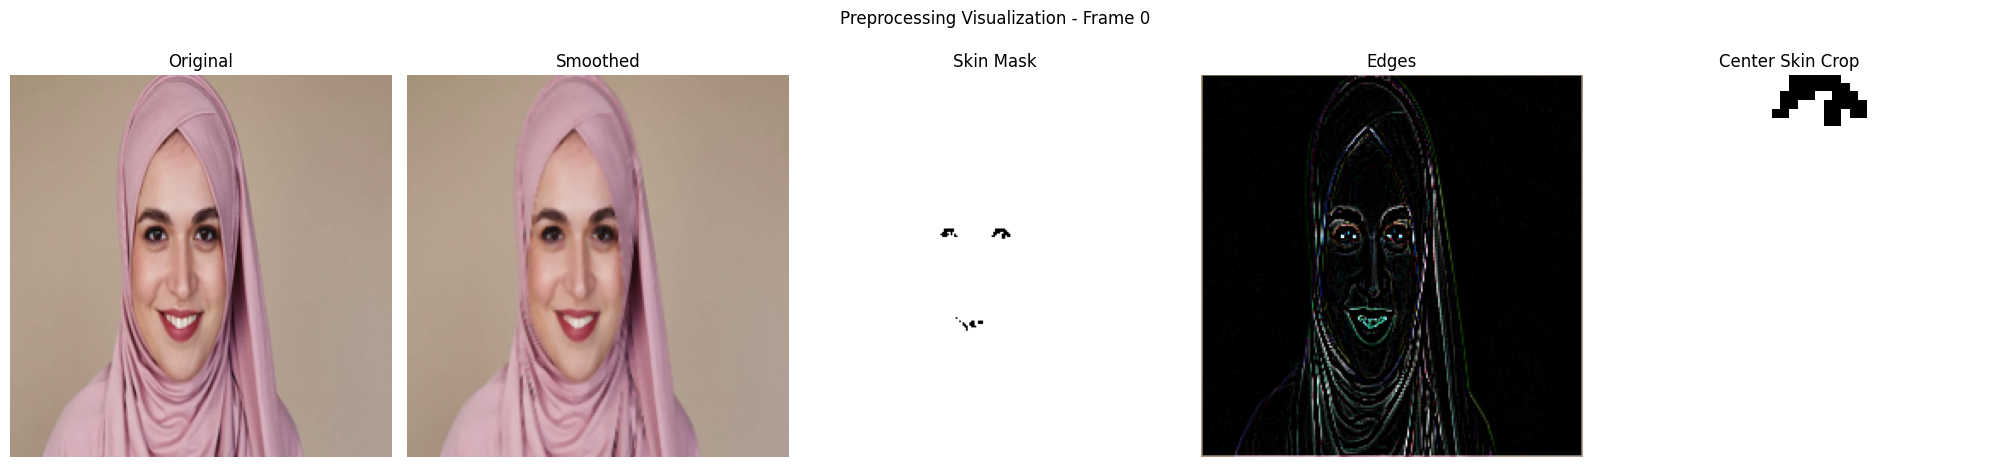

✅ Face Detected

🎯 Total videos with faces: 10/10
⏱ Completed in 21.42 seconds.


In [2]:
process_videos_for_face_check(
    r"C:\Users\kesav\OneDrive - SSN Trust\DM\lessfacedata", 
    num_samples=15,
    preview_dir="detected_faces_preview"
)